# Setup

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)
import pandas as pd
from sklearn.metrics import f1_score
import dtw
from sklearn.neighbors import KNeighborsClassifier


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



**Utility functions**

In [2]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 6

In [3]:
def get_autocorrelation(X_n): 
    N = len(X_n)
    X_n = X_n - np.mean(X_n)
    res=[]
    for tau in range(len(X_n)):
        gamma=0
        for t in range(N-tau):
            gamma += X_n[t]*X_n[t+tau]
        res.append(gamma/(N-tau))
    return np.array(res)

C:\Users\grego\AppData\Local\Temp\ipykernel_3452\1310315353.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\grego\AppData\Local\Temp\ipykernel_3452\1310315353.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


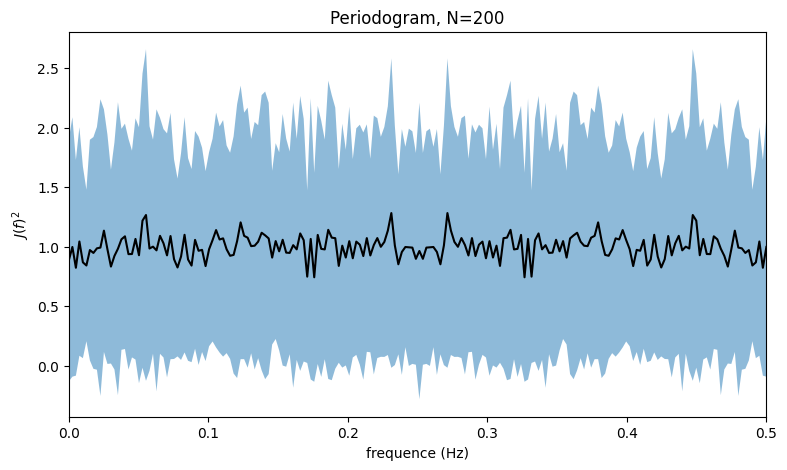

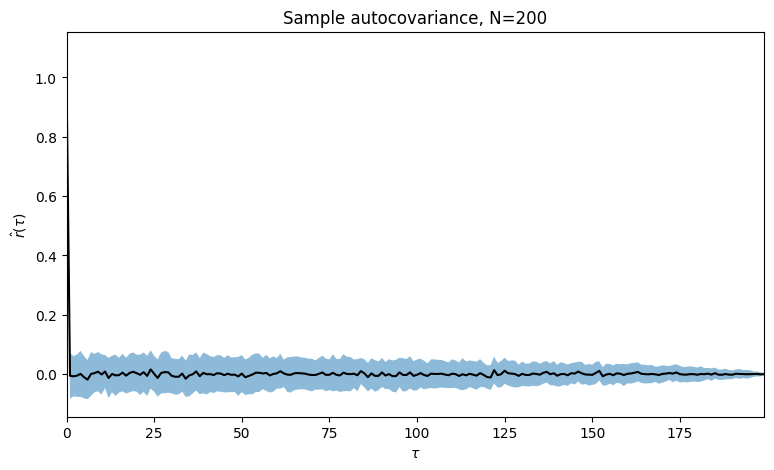

In [4]:
# This is an example of plot (random data). You can change it if you want.

## Change the following lines
N=200
sample_autocovariance=[]
periodograms=[]
for i in range(100): 
    X_n=np.array([np.random.normal(0,1) for i in range(N)])
    sample_autocovariance.append((np.correlate(X_n, X_n, mode='full')/N)[N-1:])
    # sample_autocovariance.append(get_autocorrelation(X_n))
    periodograms.append(np.abs(np.fft.fft(X_n))**2/N)
periodograms=np.array(periodograms)
sample_autocovariance=np.array(sample_autocovariance)
freqs = np.linspace(0, 0.5, N)
##


fig, ax = fig_ax(figsize=(9, 5))

avg = periodograms.mean(axis=0)
std = periodograms.std(axis=0)
ax.plot(freqs, avg, 'k-')
ax.fill_between(freqs, avg-std, avg+std, alpha=0.5)
ax.set_xlabel('frequence (Hz)')
ax.set_ylabel(r'$J(f)^2$')
ax.set_title('Periodogram, N='+str(N))
# save fig 
fig.savefig('periodogram'+str(N)+'.png')
fig.show()

fig, ax = fig_ax(figsize=(9, 5))

avg = sample_autocovariance.mean(axis=0)
std = sample_autocovariance.std(axis=0)
ax.plot([i for i in range(N)], avg, 'k-')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\hat{r}(\tau)$')
ax.set_title('Sample autocovariance, N='+str(N))
ax.fill_between([i for i in range(N)], avg-std, avg+std, alpha=0.5)
fig.savefig('sample_autocovariance'+str(N)+'.png')

fig.show()


The variance diminishes with $\tau$  which is counter intuitive as the variance should increase with the diminution of the number of points. It comes form the fact that $\hat{\gamma}$ is a sum of N-$\tau$-1 terms divided by N

## Question 9

C:\Users\grego\AppData\Local\Temp\ipykernel_3452\1519900362.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


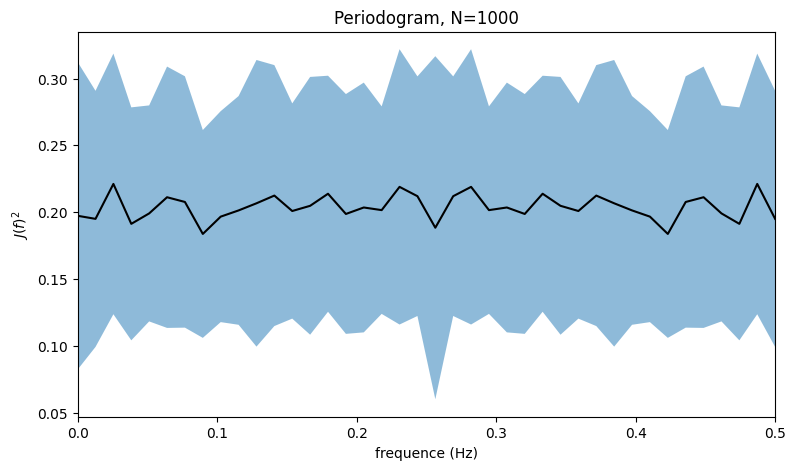

In [5]:

N=1000
periodograms=[]
for i in range(100): 
    X_n=np.array([np.random.normal(0,1) for i in range(N)])
    bar=[]
    for i in range(5): 
        x=X_n[40*i:40*(i+1)]
        bar.append(np.abs(np.fft.fft(x))**2/(N/5))
    periodograms.append(np.mean(bar, axis=0))
periodograms=np.array(periodograms)
sample_autocovariance=np.array(sample_autocovariance)
freqs = np.linspace(0, 0.5,int( 40))



fig, ax = fig_ax(figsize=(9, 5))

avg = periodograms.mean(axis=0)
std= periodograms.std(axis=0)
ax.plot(freqs, avg, 'k-')
ax.fill_between(freqs, avg-std, avg+std, alpha=0.5)
ax.set_xlabel('frequence (Hz)')
ax.set_ylabel(r'$J(f)^2$')
ax.set_title('Periodogram, N='+str(N))
# save fig 
fig.savefig('periodogram berret'+str(N)+'.png')
fig.show()



# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [6]:
# execute to find the file
from loadmydata import CONFIG
print(CONFIG["cache_home"])

C:\Users\grego\.loadmydata_datasets


In [7]:
# subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
# subset_indexes_test = [683, 259, 59, 387, 634]

# code_list = get_code_list()

# X_train = list()  # list of footstep signals
# y_train = list()  # list of pathologies (the "labels")

# for code in np.take(code_list, subset_indexes_train):
#     single_trial = load_human_locomotion_dataset(code)
#     signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
#     steps = single_trial.left_steps
#     pathology = single_trial.metadata["PathologyGroup"]
#     label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
#     for (start, end) in steps:
#         X_train.append(signal[start:end])
#         y_train.append(label)

        
# X_test = list()  # list of footstep signals
# y_test = list()  # list of pathologies (the "labels")

# for code in np.take(code_list, subset_indexes_test):
#     single_trial = load_human_locomotion_dataset(code)
#     signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
#     steps = single_trial.left_steps
#     pathology = single_trial.metadata["PathologyGroup"]
#     label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
#     for (start, end) in steps:
#         X_test.append(signal[start:end])
#         y_test.append(label)

Reading the csv files : 

In [8]:
X_train_df=((pd.read_csv('X_train.csv')))
X_test_df=((pd.read_csv('X_test.csv')))
y_train_extracted = pd.read_csv('y_train.csv').to_numpy().flatten()
y_test_extracted = pd.read_csv('y_test.csv').to_numpy().flatten()
X_train_extracted=[]
for i in range(len(X_train_df)):
    X_train_extracted.append(np.array([elt for elt in list(X_train_df.loc[i]) if not np.isnan(elt)]))

X_test_extracted=[]
for i in range(len(X_test_df)):
    X_test_extracted.append(np.array([elt for elt in list(X_test_df.loc[i]) if not np.isnan(elt)]))



In [9]:
X_train=X_train_extracted
X_test=X_test_extracted
y_train=y_train_extracted
y_test=y_test_extracted


## Question 10

In [10]:
def get_dtw_distance(X, Y):
    return dtw.dtw(X, Y, keep_internals=True).distance

Defining the distance matrix in the train_set

In [11]:
distance_matrix=np.array([[get_dtw_distance(X_train[i], X_test[j]) for j in range(len(X_test))] for i in range(len(X_train))])

In [12]:
distance_matric_x_train=np.array([[get_dtw_distance(X_train[i], X_train[j]) for j in range(len(X_train))] for i in range(len(X_train))])

In [13]:
indexs_X_train=[i for i in range(len(X_train))]
patchs=[indexs_X_train[0: 33], indexs_X_train[33: 66], indexs_X_train[66: 100], indexs_X_train[100: 134], indexs_X_train[134: 168]]

In [14]:
all_f1_scores=[]
for k in range(1, 15 ): 
    accuracies=[]
    f1_scores=[]
    for m in range(5): 
        knn = KNeighborsClassifier(n_neighbors=k)
        X_test_index=patchs[m]
        X_train_index=patchs[(m+1)%5]+patchs[(m+2)%5]+patchs[(m+3)%5]+patchs[(m+4)%5]
        dist_matrix_train=[ [ distance_matric_x_train[i][j] for j in X_train_index] for i in X_train_index]
        dist_matrix_test=[ [ distance_matric_x_train[i][j] for j in X_test_index] for i in X_train_index]
        knn.fit(dist_matrix_train, y_train[X_train_index])
        y_pred=knn.predict(np.array(dist_matrix_test).T)
        accuracies.append(np.mean(y_pred==y_train[X_test_index]))
        f1_scores.append(f1_score(y_train[X_test_index], y_pred))
    print(k,  np.mean(f1_scores))



1 0.5891498523184229
2 0.5261966861966862
3 0.5839632597224936
4 0.5252306501547988
5 0.5739338112592949
6 0.5227586206896552
7 0.5617063492063492
8 0.537703081232493
9 0.5702099334357399
10 0.5627606901725432
11 0.5825396825396825
12 0.5349175824175825
13 0.5508636598270745
14 0.5319504587056769


In [15]:

k=3 
knn = KNeighborsClassifier(n_neighbors=k)
knns = knn.fit(distance_matric_x_train, y_train)
y_pred=knns.predict(distance_matrix.T)
print(f1_score(y_test, y_pred))

0.5740740740740741


## Question 11

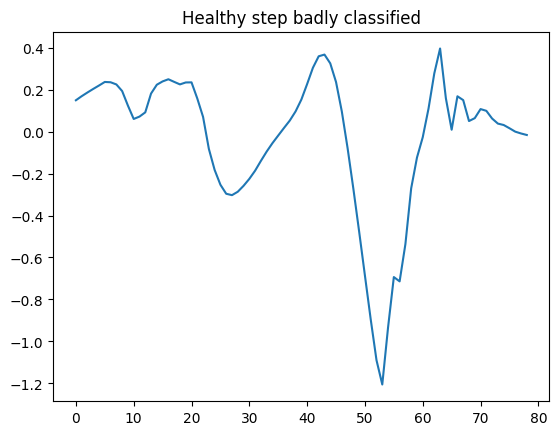

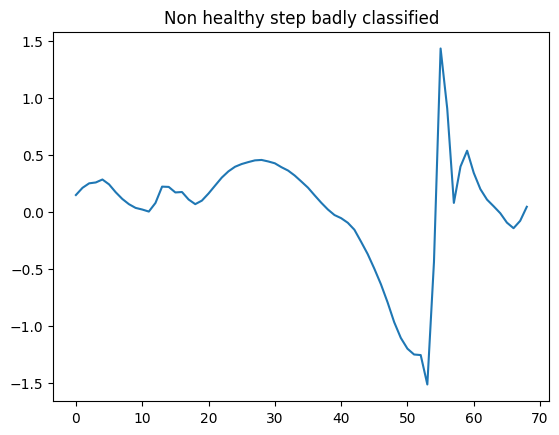

In [195]:
for i in range(len(y_test)): 
    if y_pred[i] != y_test[i] and y_test[i]==1: 
        plt.plot(X_test[i])
        plt.title('Healthy step badly classified')
        plt.savefig('Healthy step badly classified.png')
        plt.show()
        break
for i in range(len(y_test)): 
    if y_pred[i] != y_test[i] and y_test[i]==0: 
        plt.plot(X_test[i])
        plt.title('Non healthy step badly classified')
        plt.savefig('Non healthy step badly classified.png')
        plt.show()
        break